In [105]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [106]:
from fastbook import *

In [107]:
path = Path("rice_leaf_diseases")

In [108]:
print(path)

rice_leaf_diseases


In [109]:
fns = get_image_files(path)

In [110]:
failed = verify_images(fns)
failed

(#0) []

In [111]:
# failed.map(Path.unlink)

Translates the data into a DataLoaders object by telling fastAI:
- the kind of data the model will be dealing with (ImageBlock in CategoryBlock)
- how to get the data (with the `get_image_files` function)
- how to create the validation set (here we configured the `RandomSplitter` so that 20 % of our data will be dedicated to the validation set)
- how to label the data (`parent_label`)

In [112]:
rld_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

rld_datablock

`blocks=(ImageBlock, CategoryBlock)`:

The first element (`ImageBlock`) is the *independent variable*, i.e. the data from which the diseases detection model will be based on. In our case, it is images.

The second element of the tuple (`CategoryBlock`) is the *dependent variable*, i.e. what our model will try to detect. In our case, it is a category of diseases.

In [113]:
rld_dataloaders = rice_leaf_diseases_data_block.dataloaders(path)
rld_dataloaders

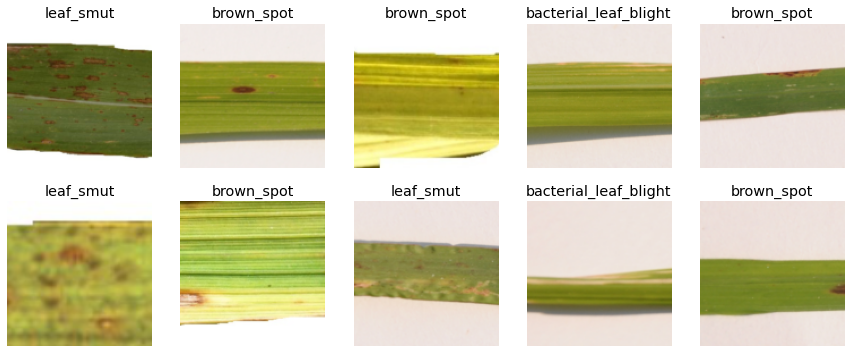

In [114]:
rld_dataloaders.show_batch(max_n=10, nrows=2)

In [115]:
rld_datablock = rld_datablock.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
rld_dataloaders = rld_datablock.dataloaders(path)
rld_dataloaders

In [116]:
learner = cnn_learner(rld_dataloaders, resnet18, metrics=error_rate)
learner.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.578549,2.768526,0.666667,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.900495,1.972784,0.625000,00:03
1,2.001125,1.396059,0.625000,00:04
2,1.714293,0.931341,0.416667,00:03
3,1.509112,0.668290,0.291667,00:04
4,1.304286,0.606718,0.208333,00:04
5,1.169026,0.586766,0.250000,00:03
6,1.081064,0.553909,0.250000,00:03
7,0.965020,0.532158,0.208333,00:03
8,0.881896,0.498595,0.208333,00:03
9,0.819496,0.464222,0.208333,00:03


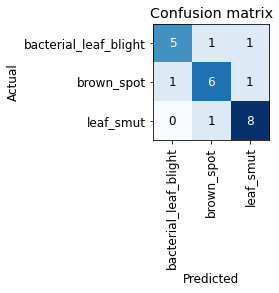

In [117]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

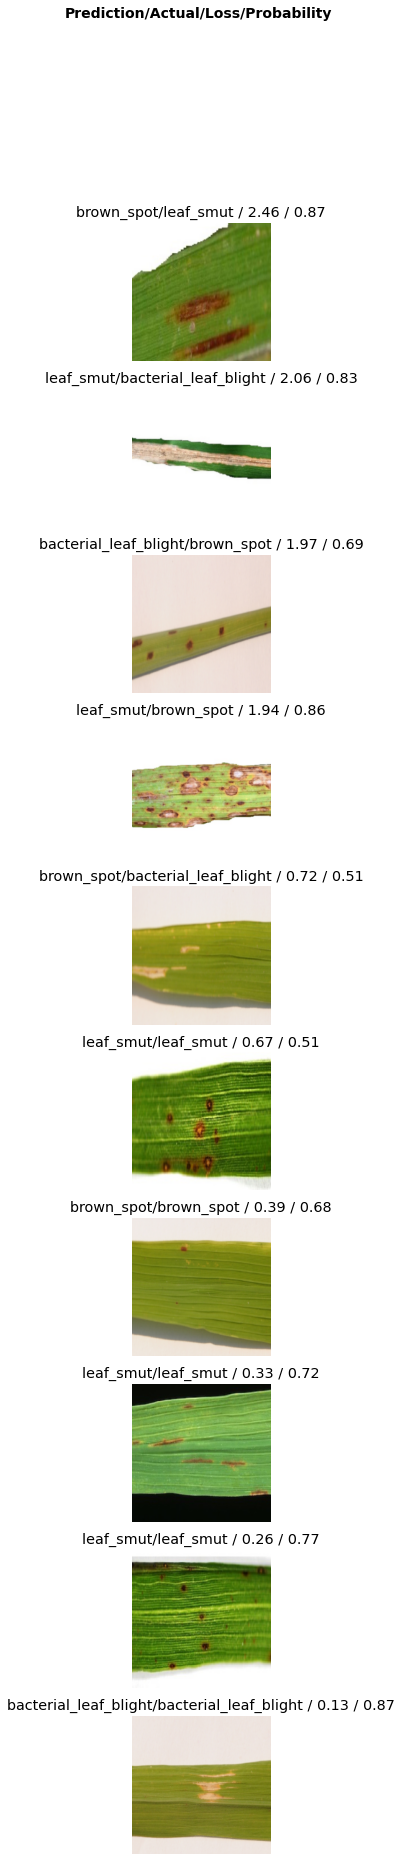

In [118]:
interp.plot_top_losses(10, nrows=10)

In [119]:
learner.export()
path = Path()
path.ls(file_exts=".pkl")
learner_inference = load_learner(path/"export.pkl")

In [120]:
learner_inference.predict("manual_validation/brown_spot.jpg")

('leaf_smut', tensor(2), tensor([0.4051, 0.0106, 0.5843]))

In [121]:
learner_inference.predict("manual_validation/bacterial_leaf_blight.jpg")

('bacterial_leaf_blight', tensor(0), tensor([0.9629, 0.0047, 0.0324]))

In [122]:
learner_inference.predict("manual_validation/leaf_smut.jpg")

('leaf_smut', tensor(2), tensor([0.2787, 0.0539, 0.6674]))